# Stochastic Gradient Descent (SGD)

Stochastic gradient descent (SGD) is a method to solve optimization problems with certain forms.

Consider an optimization problem with the following form:
$$\min_x \frac{1}{n}\sum_{i=1}^n h_i(x) + g(x) := f(x)$$
where we assume $h_i, i=1, \ldots, n$ and $g$ are all convex.

Some examples of such optimization:
1. Penalized linear regression:
   $$f(x) = \frac{1}{n}\sum_{i=1}^n (y_i - a_i^Tx)^2 + \lambda\|x\|_1$$
   Here $h_i(x) = (y_i - a_i^Tx)^2$, $n$ is the sample size;
2. SVM (linear-kernel, primal form):
   $$f(x) = \frac{1}{2n}\|x\|_2^2 + \frac{C}{n} \sum_{i=1}^n \max\{0, 1 - y_i(a_i^Tx + x_0)\} $$
   Here $h_i(x) = \max\{0, 1 - y_i(a_i^Tx + x_0)\}$, $n$ is the sample size;
3. Neurual network(1-layer, $K$ class):
   $$f(\alpha, \beta) = -\frac{1}{n}\sum_{k=1}^K\sum_{i=1}^n y_{ik}\log g_k(\beta^T \sigma(\alpha^T x_i))$$
   where $h(\alpha, \beta) = -\sum_{k=1}^K y_{ik}\log g_k(\beta^T \sigma(\alpha^T x_i))$, $n$ again is the sample size;

## Recap: gradient descent (GD)
In gradient descent method, we consider the following approach to solve the optimization problem:
$$x_{t+1} = x_t - \eta\nabla g(x_t) - \eta\frac{1}{n}\sum_{i=1}^n \nabla h_i(x_t)$$
where $x_t$ is the update at step $t$, $\eta$ the step size.

* Advantage:  
  Typical optimization algorithm; Guaranteed convergence speed (deterministic) under proper chosen stepsize $\eta$;
* Drawback:  
  When $n$ is large, it takes a long time to calculate $\nabla h_i(x)$ for all $i=1, \ldots, n$.

## Stochastic gradient descent
In order to overcome the above drawback of GD, stochastic gradient descent (SGD) algorithm iterates as follows:
$$x_{t+1} = x_t - \eta_t\nabla g(x_t) - \eta_t H(x_t)$$
where $H(x_t)$ is an unbiased estimator of $\frac{1}{n}\sum_{i=1}^n \nabla h_i(x_t)$. Here since we are talking about unbiasedness, we are implicitly assuming $H$ is a random function. 

Typically, we have the following two choices for $H(x)$:
* Vanilla SGD: $$H(x) = \nabla h_i(x)$$ where $i$ is randomly selected from $\{1, \ldots, n\}$;
* mini-batch SGD: $$H(x) = \frac{1}{|\mathcal{A}|}\sum_{i\in\mathcal{A}} \nabla h_i(x)$$
where $\mathcal{A}$ is a random subset of $\{1, \ldots, n\}$.

Not hard to verify that, due to the above random selection of index $i$ or indices $\mathcal{A}$, the resulting $H$ is a random function with $\mathbb{E}H(x) = \frac{1}{n}\sum_{i=1}^n \nabla h_i(x)$, which means it is unbiased.

### Two important points of SGD
#### Always random select the indices (shuffle $i$)
As you can see, the randomness and unbiasedness come from the randomly selected indices $i$ or $\mathcal{A}$. So it is important to always randomly select your indices before calculation;

#### Special step size $\eta_t$
Since now $H$ is a random function, the convergence issues becomes different from GD. It can be proved that, in order to have SGD present certain types of convergence, the step-size $\eta_t$ needs to satisfy specific property:
$$\sum_{t=1}^\infty \eta_t = \infty, \;\;\; \sum_{t=1}^\infty \eta_t^2 < \infty$$

A usual choice for $\eta_t$ is
$$\eta_t = \frac{c}{t ^ \alpha}, \;\;\; \frac{1}{2} < \alpha \leq 1$$

In the example below, we will pick $\alpha = 1$ and use $\eta_t = \frac{c}{t}$.

In [1]:
from __future__ import print_function
import sys
import time

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import svm

%matplotlib inline

In [2]:
y = np.loadtxt("target.txt")
X = np.loadtxt("features.txt", delimiter=',')
C = 100

In [3]:
X.shape

(6414, 122)

## Example: GD, SGD and mini-batch SGD comparison
#### Please refer to `Problem 3` of the file `SGD.pdf`

In this part we compare the performance of
* gradient descent (GD)
* stochastic gradient descent (SGD)
* mini-batch stochastic gradient descent

#### Some comments
Before proceding, there is one thing needed to be pointed out on SGD.
The procedure presented in the homework instruction is not the standard SGD.
Since you did not learn SGD in class, the point of homework is for you to know the general idea, so it skips several technical points, which however are important to guarantee the performance of SGD (as you will see below).

The missing technical points are
1. The stepsize $\eta$ need to decrease with a certain rate.  
   This is required, even just theoretically, to guarantee the convergence (rate).  
   Usually we set
   $$\eta_t = \frac{C_0}{t}$$
   in the $t$th iteration, for some constant $C_0$;
   
2. The gradient needs to be an unbiased estimator of the true gradient.  
   This requires we use
   $$w_{t+1} = w_t - \eta_t\cdot \nabla_w f(w_t, b_t; x_i, y_i)$$
   $$b_{t+1} = b_t - \eta_t\cdot \nabla_b f(w_t, b_t; x_i, y_i)$$
   in SGD, and
   $$w_{t+1} = w_t - \eta_t\cdot \frac{1}{\text{batch_size}} \sum_{i\in\text{batch}_\ell}\nabla_wf(w_t, b_t; x_i, y_i)$$
   $$b_{t+1} = b_t - \eta_t\cdot \frac{1}{\text{batch_size}} \sum_{i\in\text{batch}_\ell}\nabla_bf(w_t, b_t; x_i, y_i)$$
   in mini-batch SGD. Again, the $\eta$ should be updated as in 1.
   
#### About code
Here I code a small module in `python` call `svm`. It contains all the main functions we are going to need.

In [4]:
npr.seed(124)
svm_obj = svm.svm_gd(y, X, C, eta=36e-4, eps=0.001, fig=True)[2]
sgdsvm_obj = svm.svm_sgd(y, X, C, fig=True)[2]
mnbatsvm_obj = svm.svm_mnBat(y, X, C, eps=0.005, fig=True)[2]

AttributeError: 'generator' object has no attribute 'next'

NameError: name 'sgdsvm_obj' is not defined

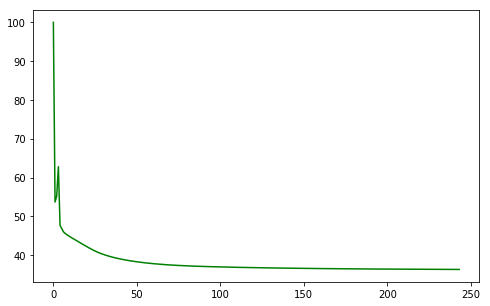

In [11]:
fg = plt.figure(figsize=(8, 5))
ax = fg.add_subplot(1, 1, 1)
l_gd = ax.plot(svm_obj, 'g-', label='GD')
l_sgd = ax.plot(sgdsvm_obj, 'r--', label='SGD')
l_miniBat = ax.plot(mnbatsvm_obj, 'b-.', label='20-SGD')
ax.set_xlim(0, 300)
ax.set_xlabel('iteration')
ax.set_ylabel('cost')
ax.legend(loc='best')

First thing we can observe is that, much smaller iteration is needed by SGD methods, especially for mini-batch SGD. The following histogram on time consumed can tell more.

In [12]:
repeat = 30
svm_time = []
sgdsvm_time = []
mnbatsvm_time = []

for i in xrange(repeat):
    start = time.time()
    svm.svm_gd(y, X, C, eta=36e-4, eps=0.001)
    end = time.time()
    svm_time.append(end - start)

    start = time.time()
    svm.svm_sgd(y, X, C)
    end = time.time()
    sgdsvm_time.append(end - start)

    start = time.time()
    svm.svm_mnBat(y, X, C, eps=0.005)
    end = time.time()
    mnbatsvm_time.append(end - start)

NameError: name 'xrange' is not defined

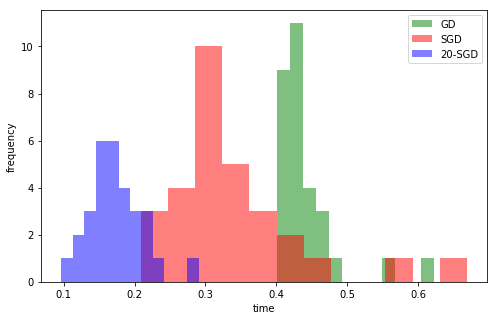

In [53]:
fg = plt.figure(figsize=(8, 5))
ax = fg.add_subplot(1, 1, 1)
h_gd = ax.hist(svm_time, color='g', alpha=0.5, label='GD', bins=12)
h_sgd = ax.hist(sgdsvm_time, color='r', alpha=0.5, label='SGD', bins=12)
h_mbBat = ax.hist(mnbatsvm_time, color='b', alpha=0.5, label='20-SGD', bins=12)
ax.set_xlabel('time')
ax.set_ylabel('frequency')
ax.legend(loc='best')

**Conclusion:**
1. The two SGD methods takes much less time than GD;
2. min-batch SGD takes similar rounds of iterations as GD to converge, but is much faster; Naive SGD converges slower than mini-batch SGD;